In [1]:
from IPython.core.display import HTML as Center

Center(
""" 
<style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
        
    }
</style> 
""")

# Enable automatic reloading of modules
%load_ext autoreload
%autoreload 2

<h1 style="text-align: center;"><strong>Python Programming for Machine Learning</strong></h1>
<br>

<h3 style="text-align: center;"><strong>ML applications</strong></h3>
<br>

<div class="term">Summer Term 2025</div>

**Stefaan Hessmann**


<div style="text-align: center;">
    <img src='images/pyt.png' width='450'>
</div>

<h1 align="center">Today's Agenda</h1>

1. **Pytorch**
    - creating datasets
    - pre-processing data with transforms
    - standard training loop

2. **Diffusion Models**
   - theory on diffusion models
   - implementation of the diffusion process
   - training a diffusion model 

**References**:
- diffusion model notebook: https://github.com/randomaccess2023/MG2023/blob/main/Video%2054/Conditional_DDPM.ipynb
- blog post: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

# Imports

In [2]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# util files
from utils import print_folder_structure, plot_mnist_images
from unet import SimpleUNet

# other imports
import os
import shutil
import kagglehub
from pprint import pprint
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from typing import List

%matplotlib inline

/home/stefaan/teaching/pyml/lecture/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MNIST: Hand-written digit dataset

<div style="text-align: center;">
    <img src='images/mnist.png' width='1000'>
</div>

- 70 000 grayscale images, size 28 × 28 px
- the “Hello World” of deep-learning vision
- tasks for todays lecture:
    - classify each image into one of 10 digits (0-9)
    - generate new samples

First of all, we will download the data from kaggle using a download function:

In [3]:
def download_mnist(data_path):
    # Check if data already exists
    if os.path.exists(data_path):
        print(f"Data already exists in {os.path.abspath(data_path)}")
        return

    # Download jpg version of mnist from kaggle
    cache_path = kagglehub.dataset_download("scolianni/mnistasjpg")

    # Create data directory if it doesn't exist
    os.makedirs(data_path, exist_ok=True)

    # Move downloaded data to our data path
    shutil.move(cache_path, data_path)

In [4]:
data_path = "mnist_data"
download_mnist(data_path)

Data already exists in /home/stefaan/teaching/pyml/lecture/2025-summer/lecture-07/mnist_data


Now, le'ts observe the folder structure of our dataset:

In [5]:
print_folder_structure(data_path, max_files=3, include_files=False)

📁 mnist_data/
  📁 1/
    📁 testSample/
      📁 testSample/
    📁 testSet/
      📁 testSet/
    📁 trainingSample/
      📁 trainingSample/
        📁 0/
        📁 1/
        📁 2/
        📁 3/
        📁 4/
        📁 5/
        📁 6/
        📁 7/
        📁 8/
        📁 9/
    📁 trainingSet/
      📁 trainingSet/
        📁 0/
        📁 1/
        📁 2/
        📁 3/
        📁 4/
        📁 5/
        📁 6/
        📁 7/
        📁 8/
        📁 9/


The data is structured as training and test set. In the train set, every subfolder is named with the label and inside the subfolder we can find the JPG images:

In [6]:
# let's see the folder structure of the zeros training set
zeros_training_path = os.path.join(data_path, "1/trainingSet/trainingSet/0")
print(f"Folder structure for: {zeros_training_path}")
print("=" * 50)
print_folder_structure(zeros_training_path, max_files=10, include_files=True)

Folder structure for: mnist_data/1/trainingSet/trainingSet/0
📁 0/
  📄 img_1.jpg
  📄 img_10007.jpg
  📄 img_10010.jpg
  📄 img_10017.jpg
  📄 img_10032.jpg
  📄 img_10039.jpg
  📄 img_10043.jpg
  📄 img_10059.jpg
  📄 img_10074.jpg
  📄 img_10082.jpg
  ...


Let's look at some example images of zeros:

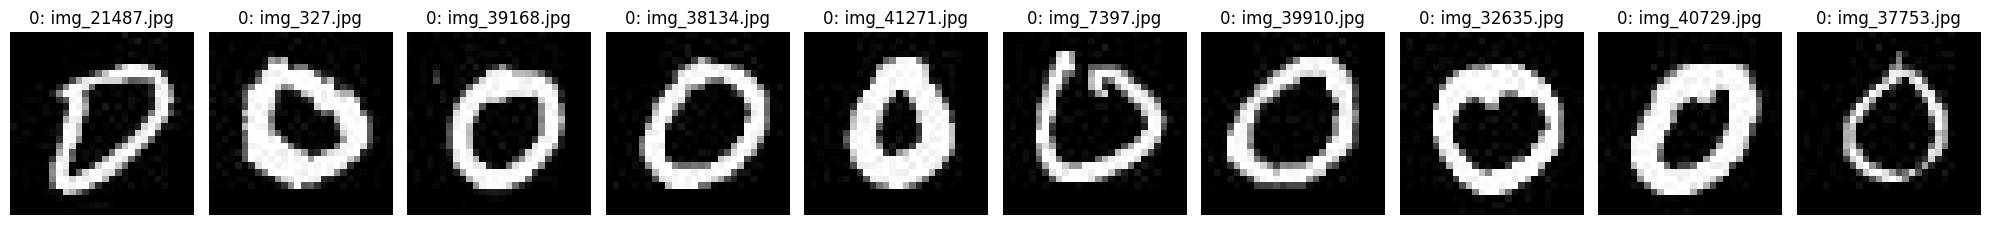

Displayed 10 MNIST 0 images


In [7]:
# Use the plot function
plot_mnist_images(data_path, digit=0, num_images=10, figsize=(20, 4))

 <h1 align="center">Efficient data processing with `torch.Dataset`</h1>

Now that we have downloaded the folder with all MNIST images, we need to find a useful structure that allows us to efficiently sample images and labels for the machine learning tasks. We can efficiently do this in `pytorch` by defining a `Dataset` class. Datasets can then easily be used for sampling data with:

```python
datapoint = dataset[idx]
```

We will start by collecting all paths to the JPG images in the subfolders, aswell as the respective labels:

In [8]:
def get_mnist_jpg_paths(data_path):
    base_path = os.path.join(data_path, '1')
    image_paths = []
    labels = []

    train_path = os.path.join(base_path, 'trainingSet', 'trainingSet')
    for digit in range(10):
        digit_path = os.path.join(train_path, str(digit))
        if not os.path.exists(digit_path):
            continue
        for img_name in os.listdir(digit_path):
            if img_name.endswith('.jpg'):
                image_paths.append(os.path.join(digit_path, img_name))
                labels.append(digit)

    return image_paths, labels

Let's have a look at the paths and labels:

In [9]:
paths, labels = get_mnist_jpg_paths(data_path=data_path)
# print 10 random paths and matching labels
ids = np.random.choice(len(paths), 10)
for id in ids:
    print(f"Path: {paths[id]}, Label: {labels[id]}")

Path: mnist_data/1/trainingSet/trainingSet/9/img_17378.jpg, Label: 9
Path: mnist_data/1/trainingSet/trainingSet/2/img_1054.jpg, Label: 2
Path: mnist_data/1/trainingSet/trainingSet/7/img_17442.jpg, Label: 7
Path: mnist_data/1/trainingSet/trainingSet/8/img_6762.jpg, Label: 8
Path: mnist_data/1/trainingSet/trainingSet/4/img_18646.jpg, Label: 4
Path: mnist_data/1/trainingSet/trainingSet/8/img_15632.jpg, Label: 8
Path: mnist_data/1/trainingSet/trainingSet/5/img_30654.jpg, Label: 5
Path: mnist_data/1/trainingSet/trainingSet/5/img_35546.jpg, Label: 5
Path: mnist_data/1/trainingSet/trainingSet/9/img_32580.jpg, Label: 9
Path: mnist_data/1/trainingSet/trainingSet/0/img_24070.jpg, Label: 0


Now we that we have found some structure in the data, we can define the dataset class `MNIST` as a subclass of `torch.utils.data.Dataset`. Our dataset should handle the following tasks:
 
 - download the data automatically
 - provide images and labels
 - show how many datapoints are available
 - allow addotional preprocessing (more on this later) 

In [10]:
class MNIST(Dataset):
    def __init__(self, data_path, transforms=None):
        self.data_path = data_path
        self.transforms = transforms or []
        self._download()
        self.image_paths, self.labels = get_mnist_jpg_paths(data_path)

    def _download(self):
        download_mnist(self.data_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path)

        # create data dict
        data_dict = dict(image=image, label=label)

        # Apply transforms
        for transforms in self.transforms:
            data_dict = transforms(data_dict)

        return data_dict

Now we will test if our `dataset` works as expected. It should automatically download the files and provide the images and labels based on the `idx`.First, we will delete the downlaoded data from the previous sections:

In [11]:
shutil.rmtree(data_path)

Next, we initialize the `dataset`, automatically download the images and sample an example image:

In [12]:
# initialize the dataset
dataset = MNIST(data_path=data_path)

# sample 1 datapoint
data = dataset[0]

# print the image
print(f"- image: {data["image"]}")

# print the label
print(f"- label: {data['label']}")

100%|██████████████████████████████████████| 68.4M/68.4M [00:06<00:00, 11.4MB/s]

Extracting files...


- image: <PIL.JpegImagePlugin.JpegImageFile image mode=L size=28x28 at 0x7BC7DEDA6B40>
- label: 0


Finally, we will sample some random ids and plot the images and their labels. For this we use the utility `view_samples`.

In [13]:
def view_samples(dataset, n_samples=10, target_key='image', label_key='label'):
    # create a figure with n_samples rows and 1 column
    fig, axis = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 1))

    # randomly select n_samples from the dataset
    ids = np.random.choice(len(dataset), n_samples)

    # loop over the selected ids and plot the images
    for i, ax in zip(ids, axis.ravel()):
        # get the image and label from the dataset
        image, label = dataset[i][target_key], dataset[i]['label']

        # load the corresponding structures and plot with `imshow`
        if type(image) == torch.Tensor:
            ax.imshow(image.squeeze(), cmap='gray', interpolation="none")
        else:
            ax.imshow(image, cmap='gray', interpolation="none")

        ax.set_title(label, fontsize=12)
        ax.axis(False);
    plt.show()

Let's plot some samples:

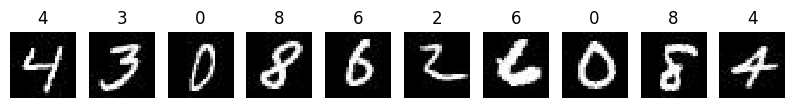

In [14]:
view_samples(dataset, n_samples=10)

The `dataset` seems to work well and we easily sample images and labels from MNIST. However, in order to train a `torch` model on the data we need to provide `torch.tensor` objects, but our dataset just provides images and `int` labels:

In [15]:
# sample 1 datapoint
data = dataset[0]

# print the type of the image and label
print(f"- image: {type(data["image"])}")
print(f"- label: {type(data['label'])}")

- image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
- label: <class 'int'>


 <h1 align="center">Data pre-processing with Transforms</h1>

 We can use transforms to further modify our data when loading without sacrificing flexibility of the dataset. This allows us to keep the dataset lightweight while still being able to easily tailor the pre-processing of data to our needs. Some examples where transforms can be very helpful include:

 - changing the `type` of our data to `torch.tensors` 
 - changing `dtypes` of `torch.tensors`
 - normalizing of data for smoother training
 - resizing images to the desired resolution
 - data augmentation
 - centering of data as for example in point clouds
 - ...

Many transforms are already implemented in `torchvision.transforms`, but we can come up with our own transforms.

**Remember:** We already implemented the use of transforms in our simple dataset:

```python
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path)

        # create data dict
        data_dict = dict(image=image, label=label)

        # ---- Apply transforms ----
        for transforms in self.transforms:
            data_dict = transforms(data_dict)

        return data_dict
```

The only restriction to the transforms in our dataset is that we decided to handle our data as `Dict` objects. So every transform should be a `Callable` that takes a dictionary as an input, modifies it and returns a dictionary.

 <h1 align="center">Let's make our own transforms</h1>

 As we already pointed out, our dataset provides images of MNIST in the wrong type. Here we will implement the following transforms:

 - `TensorTransform`: transforms the `PIL` images and `int` labels to `torch.tensor`s
 - `ResizeTransform`: allows us to change the resolution of the MNIST images
 - `NormalizeTransform`: normalizes the data for more efficient training

In [16]:
class TensorTransform(nn.Module):
    """
    Transform that converts all ints and PIL Images in a dict to torch tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, data):
        """
        Args:
            data: dict with arbitrary values
        Returns:   
            dict with ints and PIL Images converted to torch tensors
        """
        new_data = {}
        for k, v in data.items():
            # Convert int to torch tensor (long)
            if isinstance(v, int):
                new_data[k] = torch.tensor(v, dtype=torch.long)
            # Convert PIL Image to torch tensor (float32)
            elif isinstance(v, Image.Image):
                arr = np.array(v)  # Convert to numpy array
                t = torch.from_numpy(arr).float()  # Convert to float tensor
                # If grayscale image (2D), add channel dimension
                if t.dim() == 2:
                    t = t.unsqueeze(0)  # (H, W) -> (1, H, W)
                new_data[k] = t
            # Leave other types unchanged
            else:
                new_data[k] = v
        
        return new_data

In [17]:
class ResizeTransform(nn.Module): # skip
    """
    Simple transform that resizes image tensors in a dictionary.
    Assumes input is always a dict with target_key containing a tensor (nxn).
    Outputs same dict with target_key replaced by tensor (kxk).
    """
    def __init__(self, size, target_key='image'):
        """
        Args:
            size: int or tuple for target size (k or (k, k))
            target_key: key in the dictionary containing the image tensor
        """
        super(ResizeTransform, self).__init__()
        # Convert size to tuple if it's a single int
        if isinstance(size, int):
            self.size = (size, size)
        else:
            self.size = size
        self.target_key = target_key
    
    def forward(self, data):
        """
        Args:
            data: dict containing the image tensor at target_key
        Returns:
            dict with resized image at target_key
        """
        image = data[self.target_key]
        
        # Add batch and channel dimensions for interpolation
        image = image.unsqueeze(0)  # (n, n)
        
        # Resize using interpolate
        resized = F.interpolate(
            image, size=self.size, mode='bilinear', align_corners=False
        )
        
        # Remove extra dimensions
        resized = resized.squeeze(0)  # Back to (k, k)
        
        # Update the dictionary
        data[self.target_key] = resized
        return data

In [18]:
class NormalizeTransform(nn.Module): # skip
    """
    Transform that normalizes 1xnxn tensors to [0, 1]
    Works with dict input/output
    """
    def __init__(self):
        super(NormalizeTransform, self).__init__()
    
    def forward(self, data):
        """
        Args:
            data: dict with 'image' key containing torch.Tensor of shape (1, n, n)
        Returns:
            dict with normalized image in range [0, 1]
        """
        image = data['image']
        data['image'] = (image - image.min()) / (image.max() - image.min() + 1e-8)
        return data

Now, we can compare the plain dataset to the new dataset that uses transforms. First let's have a look at the plain dataset again:

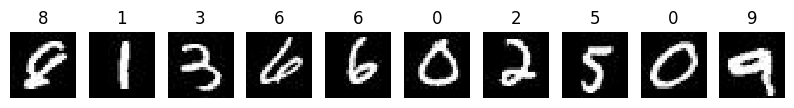

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=28x28 at 0x7BC7DEBC2900>,
 'label': 0}


In [19]:
view_samples(dataset, n_samples=10)

pprint(dataset[0])

And the new dataset with using our transforms:

Data already exists in /home/stefaan/teaching/pyml/lecture/2025-summer/lecture-07/mnist_data


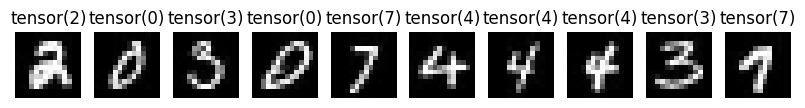

{'image': tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0050, 0.0020, 0.0060, 0.0020,
          0.0240, 0.0340, 0.0120, 0.0310, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0050, 0.0090, 0.0040,
          0.0110, 0.0200, 0.0130, 0.0130, 0.0010, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0090, 0.0050, 0.0040, 0.0230,
          0.3490, 0.4940, 0.3330, 0.0220, 0.0050, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0690, 0.4050, 0.6280, 0.8820,
          0.8690, 0.6930, 0.7450, 0.7670, 0.0070, 0.0000],
         [0.0060, 0.0040, 0.0110, 0.2020, 0.8960, 0.8290, 0.1310, 0.0130,
          0.0130, 0.0180, 0.0800, 0.9680, 0.2610, 0.0130],
         [0.0050, 0.0150, 0.0190, 0.0450, 0.6130, 0.8110, 0.0090, 0.0260,
          0.0150, 0.0360, 0.0480, 0.9580, 0.2670, 0.0120],
         [0.0050, 0.0220, 0.0140, 0.0140, 0.7440, 0.6700, 0.0140, 0.0150,
          0.0230, 0.0030, 0.4270, 0.9190, 0.1070, 0.0100],
         [0.0160, 0.0120, 0.0040, 0.0580, 0.9950, 0.3910, 0

In [20]:
dataset = MNIST(
    data_path=data_path,
     transforms=[
        TensorTransform(),
        ResizeTransform(size=(14, 14)),
        NormalizeTransform(),
        ])



view_samples(dataset, n_samples=10)
pprint(dataset[0])

 <h1 align="center">Recap on datasets and transforms</h1>

1. **Datasets**:
    - can be implemented for arbitrary types of data
    - take care of downloading and processing
    - have a `__len__` function and allow to sample by index
    - provide a clean way to distribute reusable data

2. **Transforms**:
    - allow flexible preprocessing of data, tailored to your needs
    - keep the dataset light-weight

 <h1 align="center">Training a model on MNIST</h1>

Now that we have created a dataset for loading the MNIST images and labels, we test it for training a simple label predictor. For this, we need:

- a **dataloader** for sampling batches of data from the dataset
- a **model** with trainable parameters
- a **loss function** to define a training objective
- an **optimizer** for updating the weights of our model

 <h1 align="center">Building a dataloader (skip in lecture)</h1>

First, we will start with the **dataloader**. The dataloader samples (random) datapoints from a dataset and collects them in a batch for efficient training. For complex tasks, it can be helpful to create custom dataloaders, but for our simple case we can use the native `torch.utils.data.Dataloader`. However, because we implemented a custom dataset that provides a dictionary with images and labels, we need to define a custom `collate_fn` that defines how to transform a list of single datapoints to a batch of data. In our case this means transforming `List[Dict[str, torch.tensor]]` to `Dict[str, torch.tensor]`:

In [21]:
def dict_collate_fn(batch):
    """
    Custom collate function for datasets that returns a dictionary.
    
    Args:
        batch: List of dictionaries, each containing various properties
    
    Returns:
        dict: Dictionary with collated tensors for all properties
    """    
    # Get all keys from the first sample
    keys = batch[0].keys()

    # initialize an empty dictionary
    collated_batch = {}
    
    # loop over the keys and stack the values into a tensor
    for key in keys:        
        values = [sample[key] for sample in batch]
        collated_batch[key] = torch.stack(values, dim=0)
    
    return collated_batch

Now we can define our own dataloader

In [22]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True,
    collate_fn=dict_collate_fn
)

and test it:

In [23]:
for batch in dataloader:
    print(batch['image'].shape)
    print(batch['label'].shape)
    break

torch.Size([128, 1, 14, 14])
torch.Size([128])


As we can see, the dataloader merged single datapoints to a batch with the batch size 128.

 <h1 align="center">Simple training loop</h1>

Now we can define a **simple model**, the **optimizer** and a **loss function**.

In [24]:
# very simple classifier
class SimpleClassifier(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim*dim, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize model, optimizer and loss function
model = SimpleClassifier(dim=14).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

Finally, we can put everything together and create a simple training loop. Using the `torch` optimizer makes training very easy. We just loop over the number of epochs, and in every epoch over the number of batches. Then the training step is designed as:

1. move the data to the correct device
2. remove gradients in the optimizer from previous batches
3. make a prediction with the model
4. calculate the loss function
5. compute the gradients of the loss function
6. update model weights based on gradients with the optimizer

In [25]:
# Basic training loop over 1 epoch
for epoch in range(1):

    # loop over the batches
    for batch in tqdm(dataloader):
        # 1. move data to device
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        # 2. zero the gradients
        optimizer.zero_grad()

        # 3. make a prediction
        outputs = model(images)

        # 4. compute the loss
        loss = loss_fn(outputs, labels)

        # 5. backpropagate the loss
        loss.backward()

        # 6. update the weights
        optimizer.step()

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

100%|█████████████████████████████████████████| 329/329 [00:04<00:00, 68.97it/s]

Epoch 1 - Loss: 0.7373


label: 1


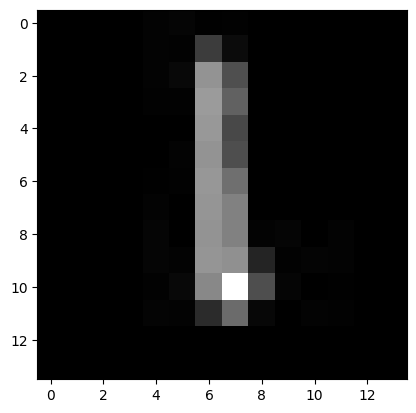

prediction: 1


In [26]:
# sample 1 datapoint
data = dataset[torch.randint(0, len(dataset), (1,))]

# plot the datapoint
print(f"label: {data['label'].item()}")
plt.imshow(data["image"].squeeze(), cmap="gray")
plt.show()

# predict the label
prediction = model(data['image'].to(device))
print(f"prediction: {prediction.argmax(dim=1).item()}")

 <h1 align="center">Recap: Training a model</h1>

 In the last section, we discussed how to train a model on our new dataset. For this, we needed a **dataloader**, a **model**, a **loss function** and an **optimizer**.

 **Dataloader**:
 - samples batches of our dataset
 - can shuffle the data during sampling
 - requires a custom collate function

 **Loss function**:
 - defines the training objective
 - `loss.backward()` propagates the loss through the computational graph and calculates gradients

 **Optimizer**:
 - updates the model parameters based on the gradients (see `loss.backward()`)

**Don't for get these steps**:
```python
        # 1. zero the gradients
        optimizer.zero_grad()

        # 2. make a prediction
        outputs = model(images)

        # 3. compute the loss
        loss = loss_fn(outputs, labels)

        # 4. backpropagate the loss
        loss.backward()

        # 5. update the weights
        optimizer.step()
```

In the last section, we discussed how to train a model on our new dataset. For this, we needed a **dataloader**, a **model**, a **loss function** and an **optimizer**.

<h1 align="center">Now let`s have a look at diffusion models </h1>

## Why diffusion models?
<div style="text-align: center;">
    <img src='images/inverse_problems.png' width='1000'>
</div>
(Image source: Khaled Kahouli)



Unlike forward problems, inverse problems are **1 to N mappings**:
- can not define a function: "cat" -> images

We need a solution to **sample** from the intractable and unknown $p_{\text{data}}(x)$
- we need generative models!


## Generating data from noise

Instead of directly sampling from the target distribution, $x_0 \sim p_{\text{data}}(x)$:
- sample from a tractable (latent) distribution, $x_T \sim q_T(x)$. E.g. Gaussian noise $\mathcal{N}(\mathbf{z}; \mathbf{0}, \mathbf{I})$.
- learn a parametrized mapping $G_{\theta}(x_T) = x_0$.

E.g. **diffusion models**, generative adversarial networks, normalizing flows, ...

<div style="text-align: center;">
    <img src='images/noise_to_distribution.png' width='1000'>
</div>

(Image source: Khaled Kahouli)


## Diffusion models
- Defining and learning $G_{\theta}(\cdot)$ can be challenging.
- But, the opposite task of **transforming the complex distribution into a simple one is easy**.

**Idea:** Split the task in 2 processes
- Use a fixed **forward process** to iteratively simplify the data, i.e. destroying the signal (right to left).
- Learn a **reverse/backward process** to undo the forward process, i.e. adding signal to noisy data (left to right).



<div style="text-align: center;">
    <img src='images/ddpm.png' width='1000'>
</div>
 

## The Fixed Forward Process

- **Mapping**: Maps $q_{\text{data}}(\mathbf{x}_0)$ to complete noise at $t = T$, $q_T(\mathbf{x}_T)$.

- Iteratively applying small Gaussian steps, following $0 = \beta_1 \le \beta_2 \le \cdots \le \beta_T \le 1$
$$
    q(x_t \mid \mathbf{x}_{t-1}) = \mathcal{N}\bigl(\mathbf{x}_t;\, \sqrt{1 - \beta_t}\, \mathbf{x}_{t-1},\, \beta_t \mathbf{I} \bigr)
$$
$$
    \mathbf{x}_t = \sqrt{1 - \beta_t}\, \mathbf{x}_{t-1} + \sqrt{\beta_t}\, \varepsilon_t, \quad \mathbf{\varepsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

- Using $\alpha_t = 1 - \beta_t, \quad \bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$ this reduces to applying one Gaussian:
  $$
  q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \, \mathbf{x}_0, (1 - \bar{\alpha}_t) \, \mathbf{I})
  $$

  $$
  \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \, \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \, \mathbf{\varepsilon}_t
  $$

- This allows for efficient sampling of $\mathbf{x}_t$ at random time step $t$, without calculating the full trajctory.


## The Learned Reverse Process

- **Goal**: We approximate to undo the forward process by learning a parameterized model 
  $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t) \approx q(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$.

- Get trained model **by minimizing the loss**:
  $$
  L = \mathbb{E}_{t \sim \mathcal{U}(1, T), \, \mathbf{x}_0 \sim q_{\mathrm{data}}, \, \mathbf{\varepsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} 
  \left[ \left\| \mathbf{\varepsilon}_t - \mathbf{\varepsilon}_{\theta}(\mathbf{x}_t, t) \right\|^2 \right]
  $$

  
- Now we can sample from from a distribution that is created by the trained model::
  $$
  p_{\theta}(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1}; \mathbf{\mu}_{\theta}(\mathbf{x}_t, t), \sigma_t^2 \mathbf{I})
  $$

  $$
  \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \mathbf{\varepsilon}_{\theta}(\mathbf{x}_t, t) \right)
  $$


## Sampling from the Diffusion Model

- **Given the trained noise model** $\boldsymbol{\epsilon}_{\theta}(\boldsymbol{x}_t, t)$:

  1. **Draw a sample** $\boldsymbol{x}_T \sim p_T(\boldsymbol{x}_T)$ from the Gaussian noise distribution.

  2. **Iteratively apply** $\boldsymbol{x}_{t-1} \sim p_{\theta}(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t)$ for $t = T, \dots, 1$:

     $$
     \boldsymbol{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \boldsymbol{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \boldsymbol{\epsilon}_{\theta}(\boldsymbol{x}_t, t) \right) + \sigma_t \, \bar{\boldsymbol{\epsilon}}, \quad \bar{\boldsymbol{\epsilon}} \sim \mathcal{N}(\boldsymbol{0}, \mathbf{I}),
     $$


# Code: Diffusion process

In [27]:
class Diffusion:
    
    def __init__(
        self,
        time_steps: int,
        beta_start: float,
        beta_end: float,
        device: str='cpu',
    ):
        """
        This class handles the forward and the backward process of our diffusion model.

        Args:
            time_steps: Maximum number of timesteps T
            beta_start: starting point of the noise schedule (how much noise we add at the first step)
            beta_end: end point of the noise schedule (how much noise we add at the last step)
            device: the device we use for training
        """
        
        # save arguments
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end 
        self.device = device

        # precompute the parameters of the noise schedule
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffuse(self, x: torch.Tensor, noise: torch.tensor, t: int):
        """
        The forward diffusion process.
        We take an image from the dataset, use sampled Gaussian noise and add the noise according to the timestep.
        I.e. for small timesteps t we only add a small amount of noise and for large timesteps we add more noise.

        Args:
            x: the datapoint at t=0 (without noise)
            noise: the noise that we want to add (not scaled yet)
            t: the timestep that defines the level of noise
        """
        # precompute scaling parameters alpha_bar and sqrt(1-alpha_bar)
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None] # add dimensions to fit data
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]

        # compute noise sample at timestep t
        x_t = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

        return x_t        

    def denoise(
        self, 
        model: nn.Module,
        num_samples: int,
        img_size,
    ): #
        r"""
        Generate a set of images from Gaussian noise.

        Args:
            model: trained model that estimates the noise \epsilon_{\theta} based on x and t
            num_samples: number of samples to generate
            img_size: resolution of the sampled images
            labels: labels for which we want to generate images. e.g. 1, 2, 3
        """
        # put model in evaluation mode
        model.eval()
        with torch.inference_mode():

            # sample starting images from Gaussian distribution
            x = torch.randn((num_samples, 1, img_size, img_size)).to(self.device)

            # empty list for collecting the generation trajectory every 100 steps
            collect = []

            # start the denoising loop (go from t=T to t=0)
            for i in tqdm(reversed(range(self.time_steps))):
                # create a tensor of timesteps
                t = (torch.ones(num_samples) * i).long().to(self.device)
                
                # predict the noise at timestep t with the noise model
                pred_noise = model(x, t) #

                # compute the scheduling parameters alpha, alpha_bar and beta
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]

                # sample noise that will be added during the reverse step
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                # compute x_{t-1} based on x_{t}, the predicted noise and the scheduling arguments
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise

                # append intermediate structure to trajectory
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        # return generated samples and sampling trajectories
        return x, collect

#  Test the forward process

Now we will have a look at the noising trajectory for our `MNIST` dataset.  
For this, we want to apply the forward noising function and plot some intermediate steps.

In [28]:
# define a range of timesteps
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()

# sample the first image of our dataset
image = dataset[0]["image"]
print('Image label:', dataset[0]["label"])

# multiply the image before adding noise
image_stack = torch.stack([image]*11)

# sample noise (this is without scaling!)
noise = torch.rand_like(image)
get_noise_stack = torch.stack([noise]*11)

Image label: tensor(0)


In [29]:
# Use the diffusion process to apply the sampled noise to our set of 11 image copies.
# In this process, the noise schedule will be applied according to the timesteps.
# For small timesteps, the noise will be scaled with a small factor and for large timesteos we add more noise
noisy_img_stack = Diffusion(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffuse(image_stack, get_noise_stack, t_step)

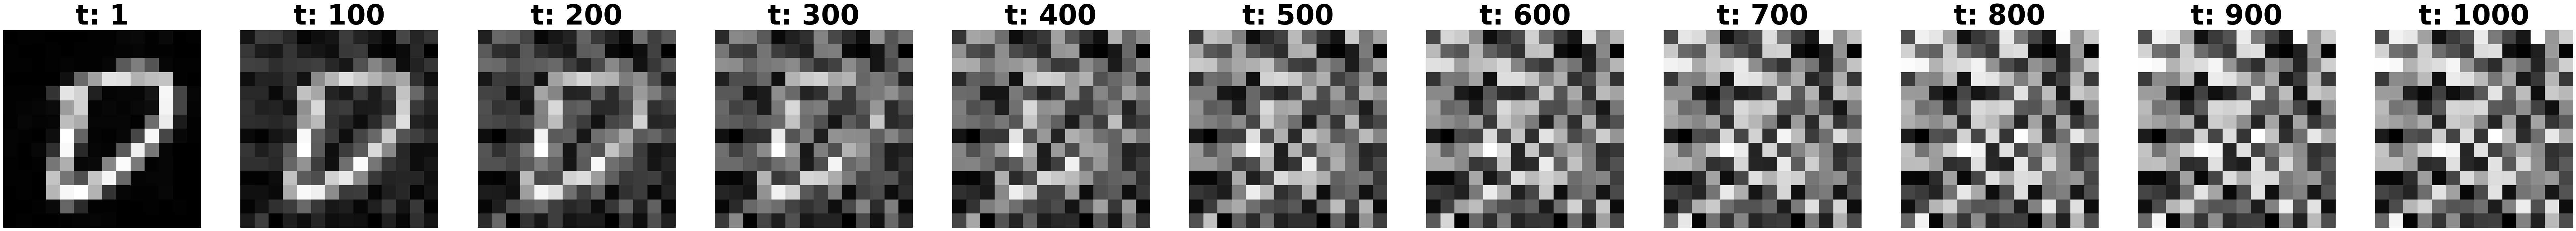

In [30]:
# now let's plot the noisy images
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f't: {t_step[idx]+1}', fontsize=60, fontweight='bold')
    ax[idx].axis(False);
plt.show()

# Code: Prepare training

Now that we have prepared the data and the diffusion process, we can prepare everything that we need for training.  
This includes:
- the **diffusion process**: `ddpm`
- the **noise model** that will be trained to predict the added noise: `model`. We use a UNet architecture that is defined in an extra file, but other model architecture can be used!
- the **loss function**: `loss_fn`
- the **optimizer**: `optimizer`

In [31]:
ddpm = Diffusion(time_steps=1000, beta_start=0.0001, beta_end=0.02, device=device)
model = SimpleUNet(in_channels=1, out_channels=1, time_dim=32, device=device).to(device) # this can be replaced with other architectures

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Code: Run training

Everything is set, and we can run our training

In [32]:
# define numbers of epochs
n_epochs = 10

# for loop over the number of training epochs
for epoch in range(n_epochs):

    # empty lists to evaluate training perfromance
    training_losses, test_losses = [], []

    # iterate over training dataset
    for batch in tqdm(dataloader):

        # zero the gradients of the optimizer
        optimizer.zero_grad()

        # put data to the device
        data = batch["image"].to(device)
        labels = batch["label"].to(device)

        # sample random timesteps between 0 and T
        t = torch.randint(low=0, high=ddpm.time_steps, size=(data.shape[0],)).to(device)
        
        # sample noise
        noise = torch.randn_like(data)
        
        # generate diffused image with forward process
        xt = ddpm.diffuse(x=data, noise=noise, t=t)
        
        # predict noise with the noise model
        pred_noise = model(xt, t)

        # compute loss
        loss = loss_fn(noise, pred_noise)
        
        # perform backward pass and optimize weights
        # this is the actual learning process!
        loss.backward()
        optimizer.step()

        # collect losses for statistics
        training_losses.append(loss.item())

        # Training on the CPU takes too much time and
        # we will load a pretrained model for this lecture.
        # However, if you want to train your own model: remove breaks!
        # print(f"We dont do the full training in this lecture")
        # break
    # break

# save the trained model
torch.save(model, "trained_unet.pt")

100%|█████████████████████████████████████████| 329/329 [01:05<00:00,  5.01it/s]


# Code: Using the trained model for denoising

After training our noise predictor, we want to test the performance on the task of data generation.
After loading the model, we can plug it into the diffusion process and sample new images, starting from Gaussian noise.

In [33]:
# load the trained model
model = torch.load("trained_unet.pt", weights_only=False, map_location=device) # use map_location to specify the device
model.device = device

In [34]:
# run the reverse process to generate a new image at t=0, based on Gaussian noise at t=1000
_, trajectory = ddpm.denoise(model=model, num_samples=1, img_size=14) # for now, we only care abou the trajectory


# save file 
with open("trajectory.pkl", "wb") as file:
    pickle.dump(trajectory, file)

1000it [00:09, 104.38it/s]


In [35]:
with open("trajectory.pkl", "rb") as file:
    trajectory = pickle.load(file)

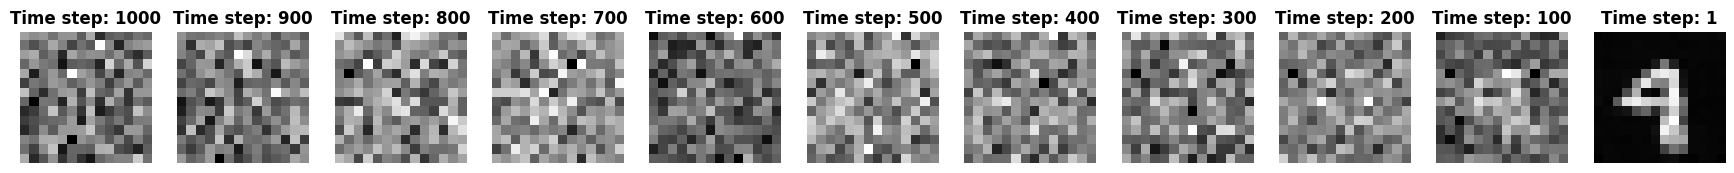

In [36]:
# plot the trajectory
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1] # define step labels

fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))
j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(trajectory[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1;
plt.show()

# Recap: Diffusion models

1. We destroy data in the **forward process** by adding Gaussian noise
2. We train a model to **estimate the noise** at every timestep
3. The **reverse process** uses the trained model to remove noise
4. **Generating data**: Sample noisy image form simple distribution and perform T denoising steps

<div style="text-align: center;">
    <img src='images/ddpm.png' width='1000'>
</div>

## Thanks for your attention!